<a href="https://colab.research.google.com/github/JDS289/DNNs/blob/main/finalC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###C: Inductive Bias of ReLU networks

I'd like to see if a probabalistic classifier will tend to learn generalisable probability reasoning, or whether this struggles to generalise beyond its training data. Will it implement Bayes' Rule, or just memorise its training distributions?

I decided to make a simple "Typo" dataset: suppose words are drawn from a distribution over a small list of words, and then as each word is typed, each letter has an independent probability of being changed to another letter, based on the keyboard-distance of the letters. Can a neural network learn the distributions of this setup, with potentially some "simplicity" in its implementation from inductive biases?

What I'm testing for, specifically:
* *Generalised probabilistic reasoning:* Can it learn to reason claims like "even though this typo is closer to X, it's more likely to have been Y because Y is a much more common word" (and vice versa) on an unseen typo?
* *Smoothness / Irrelevance-Invariance:* Will its output stay the same when modifying an irrelevant part of the input?


####Results

It turns out the string "les[" happened not to be in the training set. Let's see how the model does.

In [109]:
print(format_distribution("e") + "\n\n" + format_distribution("a"))    # the "real" distributions

Typo distribution from e:
e: 0.446, w: 0.024, r: 0.024, d: 0.024, s: 0.013, f: 0.013, q: 0.008, t: 0.008, c: 0.008, a: 0.006

Typo distribution from a:
a: 0.453, q: 0.024, s: 0.024, z: 0.024, w: 0.014, x: 0.014, d: 0.008, e: 0.007, c: 0.007, f: 0.004


In [102]:
print(format_prediction(model, "les["))    # the model's estimates

lest: 0.8616, last: 0.0799, pest: 0.0562, past: 0.0021, part: 0.0002, kart: 0.0


Single-quotes means what was intended; double-quotes means what was typed:

$$
\text{Bayesianism using the actual distributions: }~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \\ \frac{P(`\text{lest'} ~ | ~ ``\text{les["})}{P(`\text{last'} ~|~ ``\text{les["})} = \frac{P(``\text{les["} ~ | ~ `\text{lest'}) ~ P(`\text{lest'}) / P(``\text{les["})} {P(``\text{les["} ~ | ~ `\text{last'}) ~ P(`\text{last'}) / P(``\text{les["})} \\[0.3in] =
0.2 ~ \frac{{P(``\text{les["} ~ | ~ `\text{lest'}})} {{P(``\text{les["} ~ | ~ `\text{last'}})} = 0.2 ~ \frac{P(``\text{e"} ~|~ `\text{e'}) }{P(``\text{e"} ~|~ `\text{a'}) }~\approx~ 0.2 ~  \frac{0.446}{0.007} ~~\approx~ 12.7
\\[0.4in]
\text{Model's result, having never seen this example: }~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\\
\frac{0.8616}{0.0799} ~ \approx ~ 10.8
$$

This is pretty close, especially for an example it had never seen during training. In fact, something non-trivial that the model handled well: a typed "r" in second position is enough to overcome the prior of P('last') = 5 P('lest'), but a "d" in second position is not -- i.e. although 'e'→"d" is a 4× more likely typo than 'a'→"d", this is still less than the prior of 5×, whereas 'e'→"r" is **6**× more likely than 'a'→"r".
So it seems like it might have learned some generalisable notions about probability, rather than just memorising the training answers.


Another property we want -- a notion of "invariance over irrelevant changes", i.e. we don't want a change to the *final* letter to randomly change its preferences (given that all words in the sample end with "t", and my sample-generation assumed independence).

In [119]:
print(format_prediction(model, "pas.") + "\n\n" + format_prediction(model, "pas;"))

past: 0.9659, last: 0.0171, part: 0.0101, pest: 0.0068, lest: 0.0, kart: 0.0

past: 0.9718, last: 0.018, part: 0.0075, pest: 0.0028, lest: 0.0, kart: 0.0


This is quite consistent -- the percentages are very similar (though not identical), and the "preference ranking" stays identical.

Let's get some more statistical significance. Over all possible last letters in "pas ", how do the model's probability-estimates change?

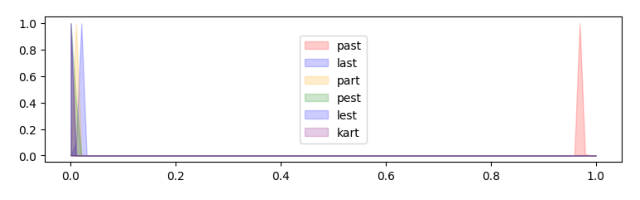

Each distribution there represents "the amount of probability deviation caused by irrelevant modifications", so the fact that these distributions are tight indicates that the model generally isn't varying its probability very much, under irrelevant changes. Again though, not infinitely tight, so not indicative of the "simple/elegant implementation" inductive bias. Still, it's nice that the model is *fairly* consistent, and there's at least some demonstration of the other inductive bias I hypothesised.

####Footnote: Implementation Details

The inputs (all four-letter strings) were encoded as follows:
we have a keyboard of 30 characters; flatten this to 1d and then use letter positions as a letter -> number encoding; now the input-layer of 120 neurons is such that neuron i is set to 1 if *letter i//30 of the input string is in keyboard-position i%30*, otherwise 0. The network outputs are put through a Softmax, and it's trained using log loss, with Adam.

I experimented with the number of hidden layers, by testing its loss on a hold-out set. I chose 10, as it seemed to work fairly well and didn't overfit much (higher numbers of layers ended up being too slow for me to train).